## EDA 및 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('Default2.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

In [3]:
# 불러온 데이터의 형태와 각 feature들의 Dtype을 살펴보기로 함.
# 범주형 변수는 Dtype이 int64인 "Bankrupt?", "Net Income Flag", "Liability-Assets Flag" 이다. 
print(df.shape)
df.info()

(6819, 96)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-

In [4]:
# 결측치는 없다는 것을 확인
df.isnull().sum().sort_values(ascending=False)

 Equity to Liability                      0
 Net Income Flag                          0
 Operating Profit Growth Rate             0
 After-tax Net Profit Growth Rate         0
 Regular Net Profit Growth Rate           0
                                         ..
 Current Liabilities/Equity               0
 Long-term Liability to Current Assets    0
 Retained Earnings to Total Assets        0
 Total income/Total expense               0
Bankrupt?                                 0
Length: 96, dtype: int64

In [5]:
# 열 이름 앞뒤 여백 정리
df = df.rename(columns=lambda x: x.strip())

In [6]:
# 데이터 종류의 파악: numeric and categorical data
numeric_features = df.dtypes[df.dtypes != 'int64'].index
categorical_features = df.dtypes[df.dtypes == 'int64'].index

df[categorical_features].columns.tolist()

['Bankrupt?', 'Liability-Assets Flag', 'Net Income Flag']

In [7]:
# Liability-Assets Flag에 대한 탐구
df['Liability-Assets Flag'].value_counts()
# 결론: 대부분의 회사들은 총부채보다 총 자산이 더 크다

0    6811
1       8
Name: Liability-Assets Flag, dtype: int64

Liability-Assets Flag  Bankrupt?
0                      0            6597
                       1             214
1                      1               6
                       0               2
dtype: int64


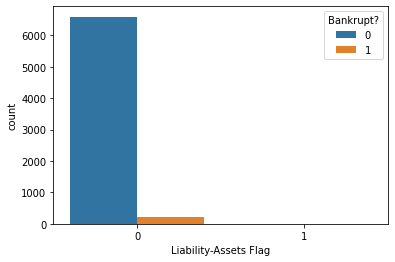

In [8]:
print(df[['Liability-Assets Flag','Bankrupt?']].value_counts())
sns.countplot(x = 'Liability-Assets Flag',hue = 'Bankrupt?',data = df)
# 결론: 분명 총부채가 더 클 경우 파산할 가능성이 더 크다

In [9]:
# Net Income Flag에 대한 탐구
print(df['Net Income Flag'].value_counts())
# 결론: New Income인 당기순이익이 최근 2년간 음수라면 1이지만, 그런 회사는 없다
# > 삭제해도 될 것 같음

1    6819
Name: Net Income Flag, dtype: int64


In [10]:
df.drop("Net Income Flag", axis=1, inplace=True)

In [11]:
# 데이터를 target변수와 feature변수로 나눠준다.
X = df.iloc[:,1:]
y = df.iloc[:,:1] # 부도여부를 target변수로 나머지를 feature로 나눠준다.
print(f"shape of X: {X.shape}")
print(f"shape of y: {y.shape}")

shape of X: (6819, 94)
shape of y: (6819, 1)


In [12]:
# y의 데이터의 분포를 살펴보니, 부도가 난 기업(1)의 데이터가 부도가 나지 않은 기업(0)의 데이터에 비해 많이 적다. 즉, 이 데이터는 불균형 데이터이다.
y.value_counts()

Bankrupt?
0            6599
1             220
dtype: int64

In [13]:
from imblearn.under_sampling import * # 언더 샘플링
from imblearn.over_sampling import * # 오버 샘플링
from imblearn.combine import * # 복합 샘플링
X_res, y_res = SMOTE(random_state=100).fit_resample(X,y)
print(f"shape of X_resampled: {X_res.shape}")
print(f"shape of y_resampled: {y_res.shape}")
y_res.value_counts()

shape of X_resampled: (13198, 94)
shape of y_resampled: (13198, 1)


Bankrupt?
1            6599
0            6599
dtype: int64

In [14]:
X = X_res
y = y_res

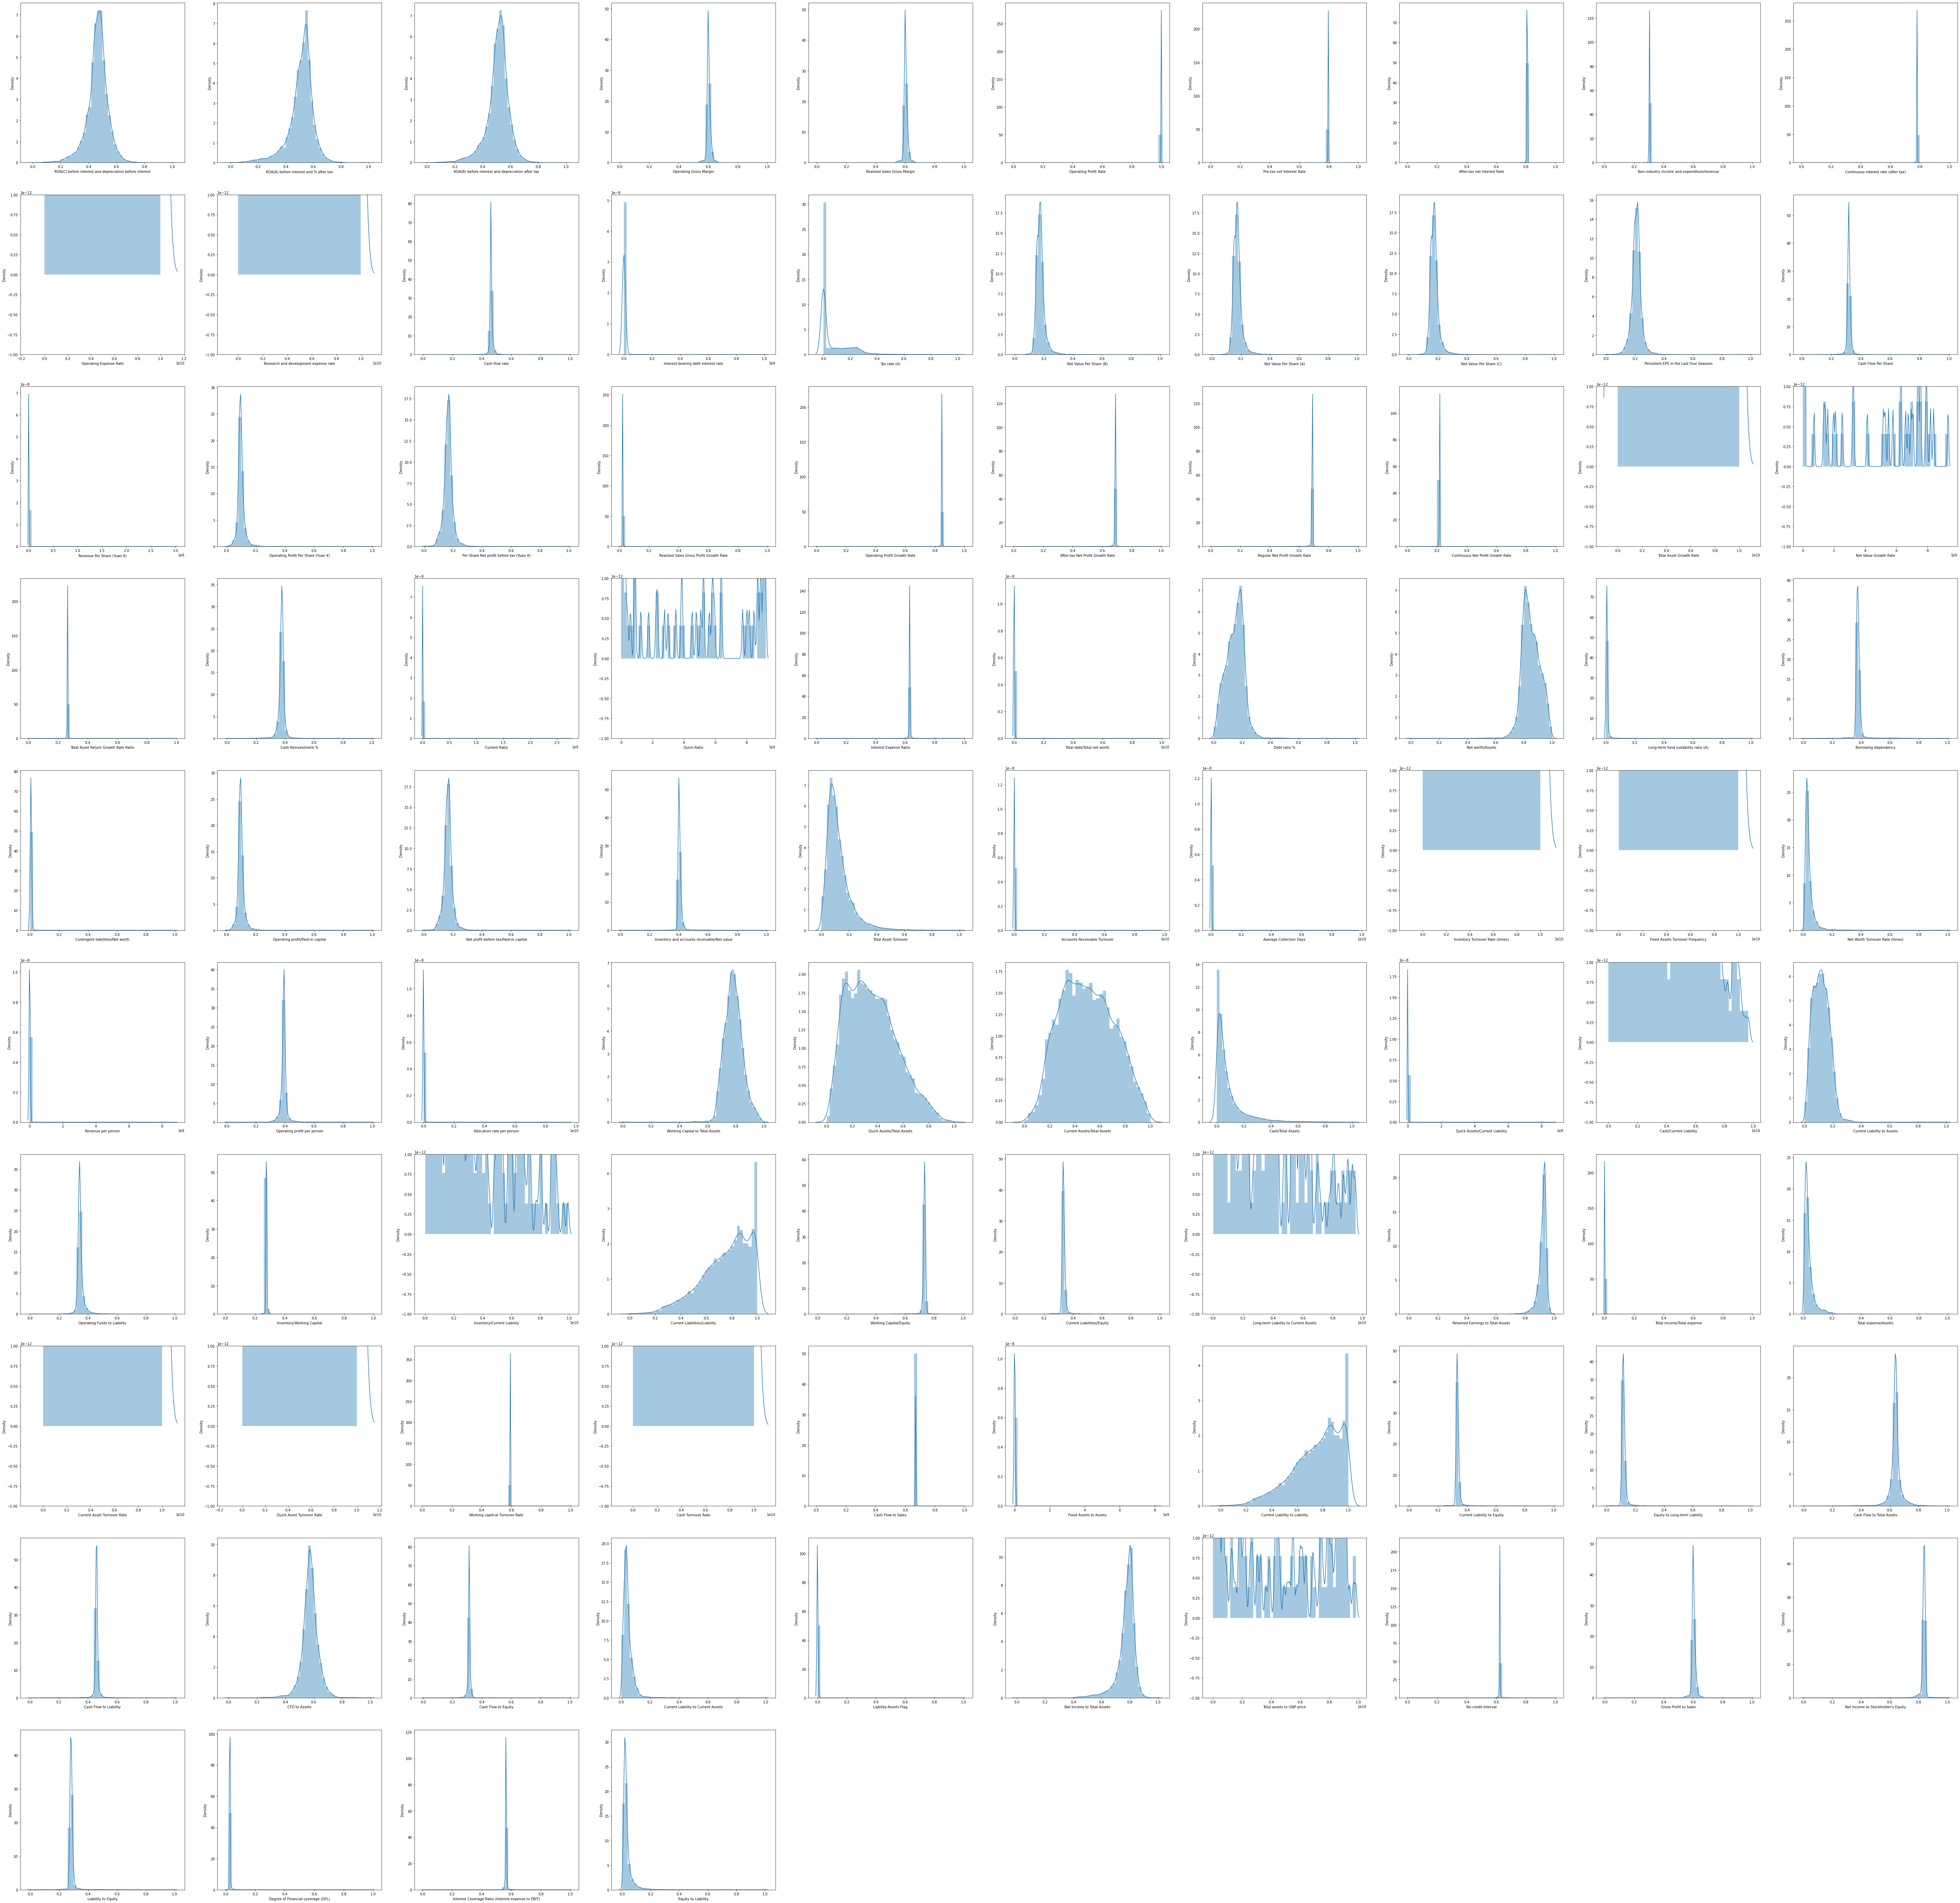

In [15]:
plt.figure(figsize=(100,100))
i = 1
for feature in X_res.columns:
  plt.subplot(10,10,i)
  sns.distplot(X_res[feature])
  i += 1
plt.show()

In [16]:
# 스케일링을 진행함
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(data=X, columns=df.columns[1:])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [18]:
# 모든 변수를 사용해서 모델들을 돌려 보기로 한다
# 부도가 난(날) 기업을 부도가 나지 않았다고 판단하는 것이 반대의 경우보다 더 위험하므로 재현율이 정밀도 보다 더 중요
from sklearn import neighbors  #KNN
from sklearn.svm import SVC    #SVC
from sklearn.linear_model import LogisticRegression  #LogisticRegression
from sklearn.tree import DecisionTreeClassifier  #DecisionTree
from sklearn.naive_bayes import GaussianNB   #가우시안
from sklearn.ensemble import RandomForestClassifier #RandomForest
from sklearn.ensemble import AdaBoostClassifier   #Adaboost
from sklearn.ensemble import GradientBoostingClassifier   #GradientBoost
from xgboost import XGBClassifier   #XGBoost
from lightgbm import LGBMClassifier  #Light GBM
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

knn = neighbors.KNeighborsClassifier()
lr = LogisticRegression()
tree = DecisionTreeClassifier()
GNB = GaussianNB()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

for model in [knn, lr, tree, GNB, rf, ada, xgb, lgbm]:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(model)
    print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f}, f1 score: {3: .4f} '.format(accuracy, precision, recall, f1))
    print()

KNeighborsClassifier()
정확도:  0.9386, 정밀도:  0.8925, 재현율:  1.0000, f1 score:  0.9432 

LogisticRegression()
정확도:  0.8985, 정밀도:  0.8827, 재현율:  0.9234, f1 score:  0.9026 

DecisionTreeClassifier()
정확도:  0.9534, 정밀도:  0.9383, 재현율:  0.9725, f1 score:  0.9551 

GaussianNB()
정확도:  0.7617, 정밀도:  0.6956, 재현율:  0.9465, f1 score:  0.8019 

RandomForestClassifier()
정확도:  0.9769, 정밀도:  0.9605, 재현율:  0.9955, f1 score:  0.9777 

AdaBoostClassifier()
정확도:  0.9322, 정밀도:  0.9249, 재현율:  0.9435, f1 score:  0.9341 

XGBClassifier()
정확도:  0.9587, 정밀도:  0.9421, 재현율:  0.9792, f1 score:  0.9603 

LGBMClassifier()
정확도:  0.9845, 정밀도:  0.9711, 재현율:  0.9993, f1 score:  0.9850 



* 여러 모델들을 하이퍼파라미터 튜닝 및 변수 선정 없이 사용 해 본 결과, 나이브베이즈를 제외한 모델들은 모두 뛰어난 성능을 보여줌. 
* 그 중에서도 특히 RandomForest, Light GBM, KNN은 좋은 성능을 보여줌.

In [19]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
preds = rf.predict(X_test)
print(accuracy_score(y_test, preds))
importance_list = dt.feature_importances_
importance_list = pd.Series(importance_list, index=X.columns).sort_values(ascending=False)
importance_df1 = pd.DataFrame(importance_list, columns=['feature_importances'])
importance_df1.head(15)

0.9768939393939394


,feature_importances
Continuous interest rate (after tax),0.502877
Debt ratio %,0.088422
Interest Expense Ratio,0.040079
Borrowing dependency,0.033678
Non-industry income and expenditure/revenue,0.019328
Degree of Financial Leverage (DFL),0.017438
Net Income to Total Assets,0.015083
Operating profit per person,0.014561
Contingent liabilities/Net worth,0.014159
Cash Turnover Rate,0.014101


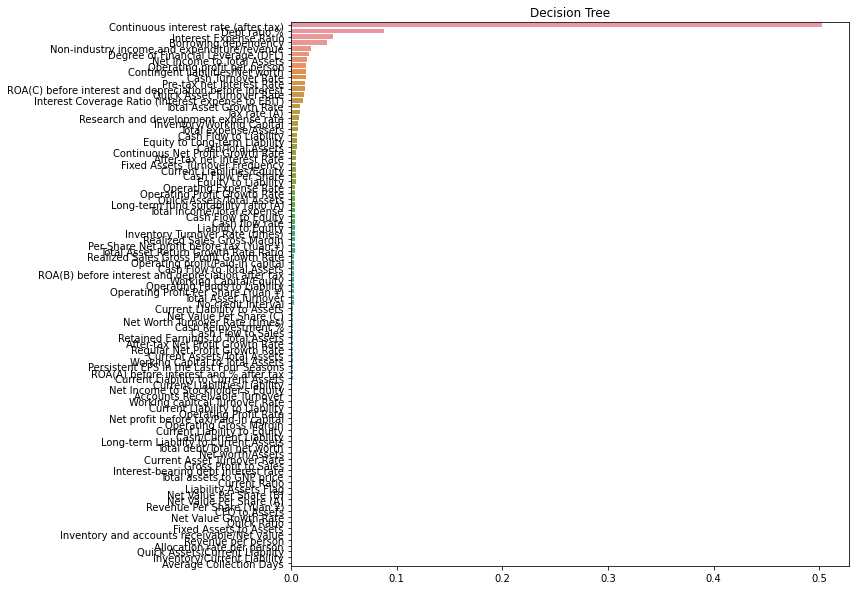

In [20]:
plt.figure(figsize=(10,10))
sns.barplot(x=importance_list, y=importance_list.index)
plt.title("Decision Tree")
plt.show()

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print(accuracy_score(y_test, preds))
importance_list = rf.feature_importances_
importance_list = pd.Series(importance_list, index=X.columns).sort_values(ascending=False)
importance_df1 = pd.DataFrame(importance_list, columns=['feature_importances'])
importance_df1.head(15)

0.9761363636363637


,feature_importances
Continuous interest rate (after tax),0.057514
Persistent EPS in the Last Four Seasons,0.051750
Retained Earnings to Total Assets,0.048687
After-tax net Interest Rate,0.040511
Net Income to Total Assets,0.039421
Pre-tax net Interest Rate,0.039234
Per Share Net profit before tax (Yuan ¥),0.039187
Borrowing dependency,0.038529
Debt ratio %,0.036985
ROA(C) before interest and depreciation before interest,0.032974


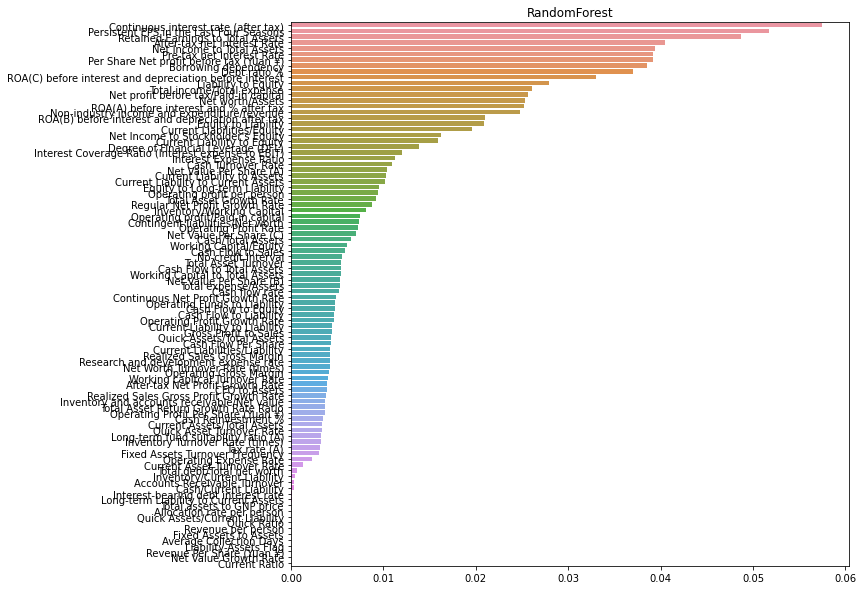

In [22]:
plt.figure(figsize=(10,10))
sns.barplot(x=importance_list, y=importance_list.index)
plt.title("RandomForest")
plt.show()

0.9321969696969697


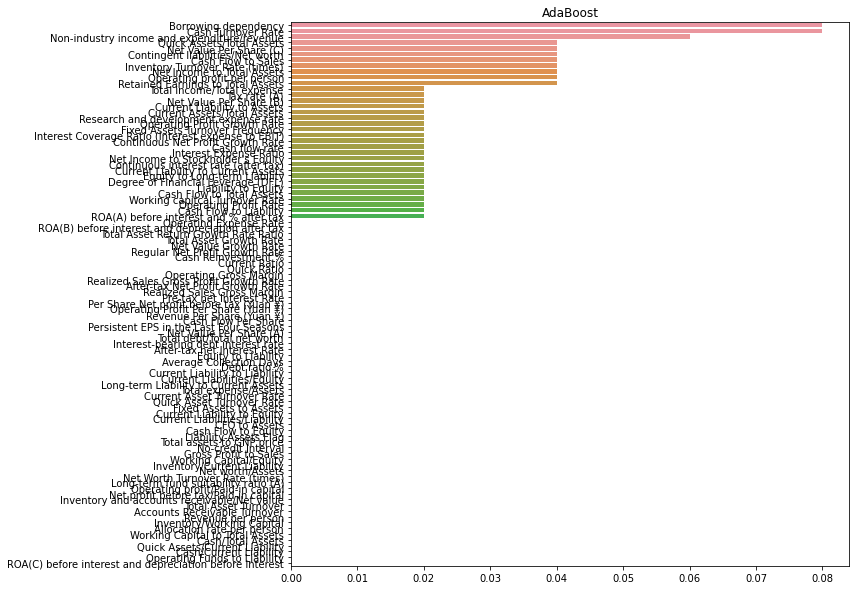

In [23]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
preds = ada.predict(X_test)
print(accuracy_score(y_test, preds))
importance_list = ada.feature_importances_
importance_list = pd.Series(importance_list, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,10))
plt.title("AdaBoost")
sns.barplot(x=importance_list, y=importance_list.index)
plt.show()

0.984469696969697


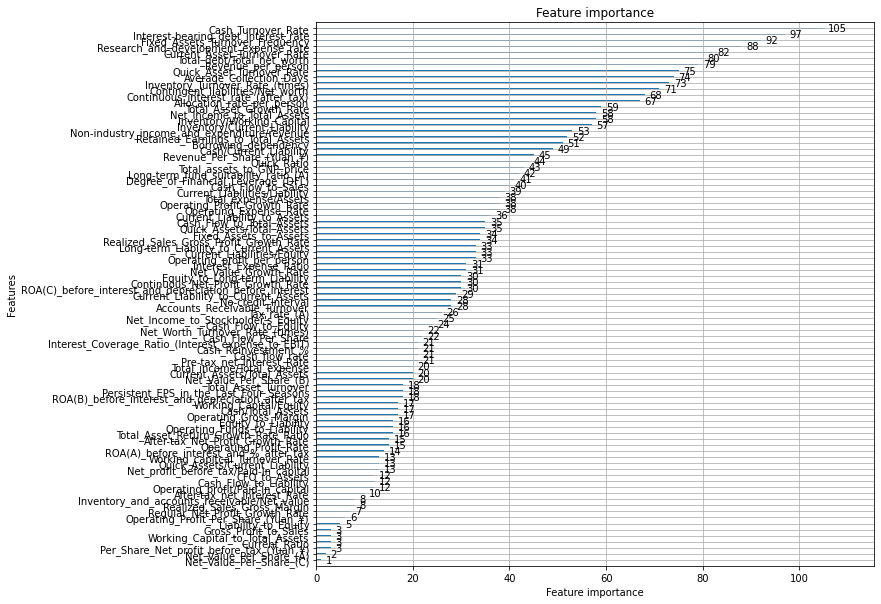

In [24]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
preds = lgbm.predict(X_test)
print(accuracy_score(y_test, preds))

from lightgbm import plot_importance as lgbm_plot

fig, ax = plt.subplots(figsize=(10,10))
lgbm_plot(lgbm, ax=ax)

0.9587121212121212


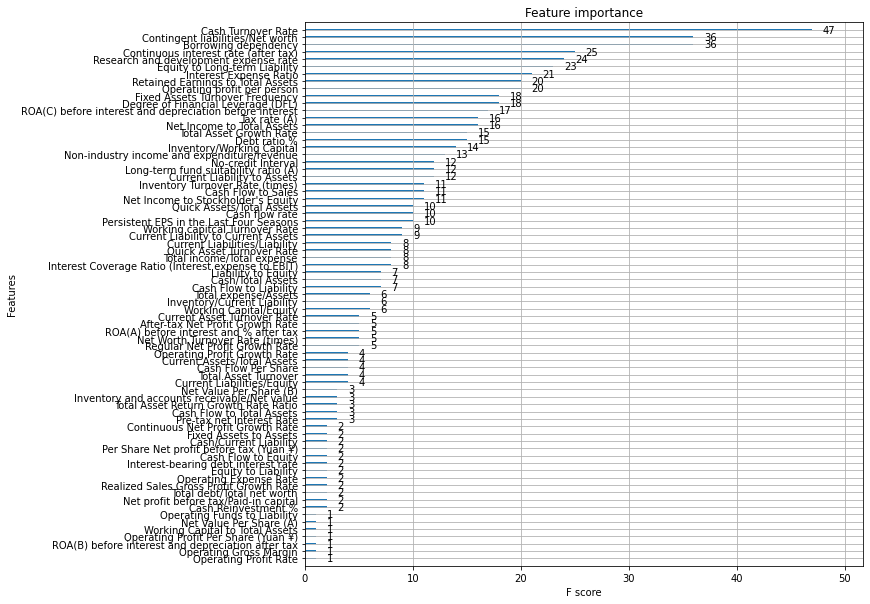

In [25]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
print(accuracy_score(y_test, preds))

from xgboost import plot_importance as xgb_plot
fig, ax = plt.subplots(figsize=(10,10))
xgb_plot(xgb, ax=ax)

## 다양한 모델들 사용 및 평가 (변수 선택을 적용)

In [26]:
# sklearn에서 제공하는 sklearn.selection의 RFE를 사용해 feature_selection을 진행해 보기로 한다.
# 과정을 보여주기 위해 로지스틱회귀모델에 RFE를 적용하는 것을 보여준다.

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()

rfe = RFE(lr_clf, n_features_to_select=10, step=1)
rfe = rfe.fit(X_train, y_train)

In [27]:
feature_selected = pd.DataFrame(X.columns[rfe.support_], columns=["features"])
feature_selected

,features
0,ROA(C) before interest and depreciation before...
1,ROA(A) before interest and % after tax
2,Net Value Per Share (B)
3,Net Value Per Share (C)
4,Persistent EPS in the Last Four Seasons
5,Debt ratio %
6,Borrowing dependency
7,Inventory and accounts receivable/Net value
8,Net Income to Total Assets
9,Liability to Equity


In [28]:
dict_data = {'feature_name':X.columns, 'score': rfe.ranking_}
pd.DataFrame(dict_data).sort_values(by='score', ascending=True).reset_index(drop=True)

,feature_name,score
0,ROA(C) before interest and depreciation before...,1
1,Borrowing dependency,1
2,Persistent EPS in the Last Four Seasons,1
3,Net Value Per Share (C),1
4,Net Value Per Share (B),1
...,...,...
89,Total Asset Return Growth Rate Ratio,81
90,Tax rate (A),82
91,No-credit Interval,83
92,Current Ratio,84


In [29]:
X_train = X_train[X.columns[rfe.support_]]
X_test = X_test[X.columns[rfe.support_]]

# 로지스틱회귀를 사용해 보기로 함.
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
preds = lr_clf.predict(X_test)
print(accuracy_score(y_test, preds))

0.8859848484848485


In [30]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression  #LogisticRegression
from sklearn.tree import DecisionTreeClassifier  #DecisionTree
from sklearn.ensemble import RandomForestClassifier #RandomForest
from sklearn.ensemble import AdaBoostClassifier   #Adaboost
from xgboost import XGBClassifier   #XGBoost
from lightgbm import LGBMClassifier  #Light GBM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings('ignore')

def feature_selection(model, X, y, n_features_to_select):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
  original_model = model
  model1 = RFE(model, n_features_to_select=n_features_to_select, step=1)
  model1 = model1.fit(X_train,y_train)
  feature_selected = pd.DataFrame(X.columns[model1.support_], columns=["features"])
  print(model)
  print(feature_selected)
  X_train = X_train[X.columns[model1.support_]]
  X_test = X_test[X.columns[model1.support_]]
  original_model.fit(X_train, y_train)
  preds = original_model.predict(X_test)
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds)
  recall = recall_score(y_test, preds)
  f1 = f1_score(y_test, preds)  
  print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f}, f1 score: {3: .4f} '.format(accuracy, precision, recall, f1))
  print()

In [31]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model_list = [lr, dt,rf, ada, xgb, lgbm]

for model in model_list:
  feature_selection(model, X, y, 10)

LogisticRegression()
                                            features
0  ROA(C) before interest and depreciation before...
1             ROA(A) before interest and % after tax
2                            Net Value Per Share (B)
3                            Net Value Per Share (C)
4            Persistent EPS in the Last Four Seasons
5                                       Debt ratio %
6                               Borrowing dependency
7        Inventory and accounts receivable/Net value
8                         Net Income to Total Assets
9                                Liability to Equity
정확도:  0.8860, 정밀도:  0.8761, 재현율:  0.9041, f1 score:  0.8899 

DecisionTreeClassifier()
                                      features
0  Non-industry income and expenditure/revenue
1         Continuous interest rate (after tax)
2                               Cash flow rate
3                       Interest Expense Ratio
4                                 Debt ratio %
5                         B

## 다양한 모델들 사용 및 평가 (직접 변수를 선정)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
feature_list = ["Cash Turnover Rate", "Interest Expense Ratio","Net Income to Stockholder's Equity",
                "Degree of Financial Leverage (DFL)","Research and development expense rate","Cash/Total Assets", 
                "Net Income to Total Assets", "Equity to Liability", "Total income/Total expense", "Cash flow rate",
                "Interest Coverage Ratio (Interest expense to EBIT)", "Contingent liabilities/Net worth"]

In [33]:
knn = neighbors.KNeighborsClassifier()
lr = LogisticRegression()
tree = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

X_train = X_train[feature_list]
X_test = X_test[feature_list]

for model in [knn, lr, tree, rf, ada, xgb, lgbm]:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(model)
    print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f}, f1 score: {3: .4f} '.format(accuracy, precision, recall, f1))
    print()

KNeighborsClassifier()
정확도:  0.9379, 정밀도:  0.8982, 재현율:  0.9903, f1 score:  0.9420 

LogisticRegression()
정확도:  0.8580, 정밀도:  0.8514, 재현율:  0.8736, f1 score:  0.8624 

DecisionTreeClassifier()
정확도:  0.9390, 정밀도:  0.9259, 재현율:  0.9569, f1 score:  0.9411 

RandomForestClassifier()
정확도:  0.9739, 정밀도:  0.9597, 재현율:  0.9903, f1 score:  0.9748 

AdaBoostClassifier()
정확도:  0.9061, 정밀도:  0.8955, 재현율:  0.9234, f1 score:  0.9092 

XGBClassifier()
정확도:  0.9379, 정밀도:  0.9221, 재현율:  0.9591, f1 score:  0.9402 

LGBMClassifier()
정확도:  0.9693, 정밀도:  0.9560, 재현율:  0.9851, f1 score:  0.9703 



## 번외: PCA

* PCA를 진행을 하게되는 경우, 어떤 변수가 영향을 미치는 지 알기가 어렵다.  
이는 PCA의 결과로 생성된 주성분이 원본 데이터에 있는 여러 특성들이 조합된 형태이기 때문이다.  
따라서 어떤 변수들이 부도여부에 큰 영향을 미치는 지 파악하고, 중요한 소수의 변수들로 모든 변수를 다 사용했을 때와 비슷한 수준의 정확도와 재현율로 부도여부를 예측하는 모델을 만드는 것을 목표로 했던 이번 프로젝트에서는 PCA를 사용하지 않았다.

In [34]:
df = pd.read_csv("Default2.csv")
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

In [35]:
# 열 이름 앞뒤 여백 정리
df = df.rename(columns=lambda x: x.strip())

In [36]:
#over sampling - SMOTE

from imblearn.over_sampling import *

X = df.iloc[:,1:]
y = df.iloc[:,0]

X_res, y_res = SMOTE(random_state=100).fit_resample(X,y)

print('the shape of X_res: ', X_res.shape)
print('the shape of y_res: ', y_res.shape)

print('counts of label 1: ', sum(y_res==1))
print('counts of label 0: ', sum(y_res==0))

the shape of X_res:  (13198, 95)
the shape of y_res:  (13198,)
counts of label 1:  6599
counts of label 0:  6599


In [37]:
X = X_res
y = y_res

In [38]:
#feature scaling  - 서로 다른 범위의 변수들의 크기 통일하기위해 변환하는 작업 - 안해도 될듯?

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [39]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)
result = pd.DataFrame({'고윳값':pca.explained_variance_, '기여율':pca.explained_variance_ratio_})
result['누적기여율'] = result['기여율'].cumsum()

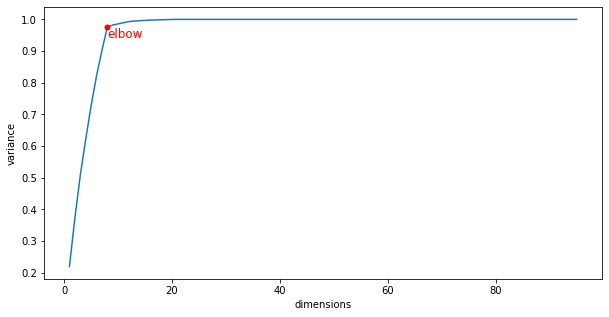

In [40]:
plt.figure(figsize=(10,5))
plt.plot(result.index +1, result['누적기여율'])
plt.xlabel('dimensions')
plt.ylabel('variance')
plt.plot(8, result['누적기여율'][7],marker='o', color='r', markersize=5)
plt.text(8, result['누적기여율'][7], 'elbow',color='r', verticalalignment='top', size=12)
plt.show()

In [41]:
result.query('누적기여율>0.95 and 누적기여율<1' ) #PCA 해봐도 될것같음

,고윳값,기여율,누적기여율
7,4.951047e+18,0.074233,0.974475
8,4.967871e+17,0.007449,0.981924
9,2.459388e+17,0.003687,0.985611
10,2.444906e+17,0.003666,0.989277
11,2.422064e+17,0.003631,0.992908
12,1.055588e+17,0.001583,0.994491
13,7.616601e+16,0.001142,0.995633
14,7.351673e+16,0.001102,0.996735
15,5.959105e+16,0.000893,0.997629
16,3.726148e+16,0.000559,0.998187


In [42]:
pca = PCA(n_components=8)
X_reduced = pd.DataFrame(pca.fit_transform(X), columns=range(1,9,1))

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.2, random_state=100)

In [44]:
knn = neighbors.KNeighborsClassifier()
lr = LogisticRegression()
tree = DecisionTreeClassifier()
GNB = GaussianNB()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

for model in [knn, lr, tree, GNB, rf, ada, gb, xgb, lgbm]:
    model.fit(X_train, y_train)
    pred_model = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred_model)
    
    print('{0}: {1: .4f}'.format(model, accuracy))

KNeighborsClassifier():  0.9220
LogisticRegression():  0.6170
DecisionTreeClassifier():  0.9125
GaussianNB():  0.6553
RandomForestClassifier():  0.9580
AdaBoostClassifier():  0.7432
GradientBoostingClassifier():  0.8303
XGBClassifier():  0.8295
LGBMClassifier():  0.9231


In [45]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[100],
         'min_samples_leaf':[1,2,4],
         'min_samples_split':[2,4,6]}

rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, param_grid=params, cv=2)
grid_rf.fit(X_train, y_train)

print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.9245122182231483


In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pred_rf = grid_rf.predict(X_test)
accuracy = accuracy_score(y_test, pred_rf)
precision = precision_score(y_test, pred_rf)
recall = recall_score(y_test, pred_rf)
f1 = f1_score(y_test, pred_rf)
                          
print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f}, f1 score: {3: .4f} '.format(accuracy, precision, recall, f1))

정확도:  0.9595, 정밀도:  0.9447, 재현율:  0.9777, f1 score:  0.9609 


In [47]:
#2) XGBoost

params = {'n_estimators':[100, 500],
         'learning_rate':[0.05,0.1, 0.3],
         'max_depth':[3,4,6]}

xgb = XGBClassifier()
grid_xgb = GridSearchCV(xgb, param_grid=params, cv=2)
grid_xgb.fit(X_train, y_train)

print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 500}
0.920250047357454


In [48]:
pred_xgb = grid_xgb.predict(X_test)
accuracy = accuracy_score(y_test, pred_xgb)
precision = precision_score(y_test, pred_xgb)
recall = recall_score(y_test, pred_xgb)
f1 = f1_score(y_test, pred_xgb)
                          
print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f}, f1 score: {3: .4f} '.format(accuracy, precision, recall, f1))

정확도:  0.9481, 정밀도:  0.9284, 재현율:  0.9732, f1 score:  0.9503 
